In [1]:
# -*- coding: utf-8 -*-

# Data aggregation and vizualization
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import graphviz
from IPython import display
import copy
import random
import pickle
import pylab as pl
%matplotlib inline

# Scraping
from bs4 import BeautifulSoup
import requests
import re
from time import sleep
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import os
chromedriver = '/Users/RJ/chromedriver'
os.environ['webdriver.chrome.driver'] = chromedriver

# Modeling
from scipy.optimize import curve_fit
from sklearn import cross_validation, datasets
from sklearn import linear_model
from sklearn import grid_search
from sklearn import tree
from sklearn.tree import export_graphviz
import sklearn.preprocessing as pp
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor

/Users/RJ/anaconda/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Load data and compile "other info" df

mov = pd.read_csv('/Users/RJ/ds/metis/metisgh/movies_05_16.csv').iloc[:,1:]

fileObject = open('other','r')  
other = pickle.load(fileObject)
fileObject = open('actor_points','r')  
actor_points = pickle.load(fileObject)
fileObject = open('director_points','r')  
director_points = pickle.load(fileObject)
fileObject = open('franchise_info','r')  
franchise_info = pickle.load(fileObject)
fileObject = open('ratings_search','r')  
ratings_search = pickle.load(fileObject)

other_info = []
for i in other:
    mov_other = {}
    mov_other['movie'] = i[0][0]
    mov_other['year'] = i[0][1]
    for k,v in i[1].items():
        if 'Domestic Total' in k:
            mov_other['Domestic Total'] = v
        elif 'Budget' in k:
            mov_other['Budget'] = v
        else:
            mov_other[k] = v
    for k,v in i[2].items():
        rename = k.split(' ')[-1].split(':')[0]
        if rename[-1] == 's':
            rename = rename[:-1]
        mov_other[rename] = v
    other_info.append(mov_other)

other_info = pd.DataFrame(other_info)

# Budget cleaning
budget = other_info.Budget.str.replace('$', '').str.replace(',', '').fillna('N/A')
budget[budget.str.contains('million')] = [float(i[0])*1000000 
                                          for i in list(budget[budget.str.contains('million')].str.split(' '))]
budget[budget=='N/A'] = np.nan
other_info.Budget = pd.to_numeric(budget)

# Use release dates from daily gross charts
del other_info['Release Date']

# Runtime cleaning
runtime = other_info.Runtime.fillna('N/A')
runtime[runtime.str.contains('hrs.')] = [(int(i[0])*60 + int(i[2])) 
                                         for i in list(runtime[runtime.str.contains('hrs.')].str.split(' '))]
runtime[runtime=='N/A'] = np.nan
other_info.Runtime = pd.to_numeric(runtime)

other_info = pd.merge(pd.merge(other_info, pd.DataFrame(director_points), 
                               how='left'), pd.DataFrame(actor_points), how='left')

In [3]:
# Reformat movies DF

mov.columns = ['LW','YD','avg','Date','Day','Day_Num','GTD','Gross','Rank','Theaters','movie','year']

min_release_length = 40
mov.Day_Num = pd.to_numeric(mov.Day_Num)
t = mov.groupby(['movie','year'])['Day_Num'].count()
long_release = list((t[t>min_release_length]).index)

mov.Gross = pd.to_numeric(mov.Gross.str.replace('$','').str.replace(',',''))
mov.Date = pd.to_datetime(mov.Date)
mov.Theaters = pd.to_numeric(mov.Theaters.str.replace(',',''))
mov.avg = pd.to_numeric(mov.avg.str.replace('$','').str.replace(',','').str.replace('n/a', '-1'))
mov.avg[mov.avg==-1] = np.nan
mov.GTD = pd.to_numeric(mov.GTD.str.replace('$','').str.replace(',','').str.replace('n/a', '-1'))
mov.GTD[mov.GTD==-1] = np.nan
mov.Rank = pd.to_numeric(mov.Rank.str.replace('-',''))

# Append movie release information

release = mov.groupby(['movie','year'],as_index=False)['Date'].first()
release.columns=['movie','year','release']
mov = pd.merge(mov,release, how='left')
mov['rmonth'] = mov.release.dt.month
mov['rday'] = mov.release.dt.dayofweek

/Users/RJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/RJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Error Calculation and Plotting

In [4]:
# Create weekly aggregations by movie and fit exponential 
# decay curve to each movie with long release

t = mov.sort_values(['movie','Date']).groupby(['movie','year']).cumcount()+1
t = t.rename('fixed_day_count')
t = pd.concat([mov, t], axis=1)
t = t.groupby(['movie','year','fixed_day_count']).sum()
t = t.groupby(level=(0,1)).cumsum().reset_index()
t = t[t.fixed_day_count%7==0].groupby(['movie','year','fixed_day_count']).sum()
t = (t-t.groupby(level=0).shift(1).fillna(0)).reset_index()

def func(x, a, b):
    return a*np.exp(-b*x)

errors = {}

for movie in long_release:
    mov_fit = t[(t.movie==movie[0]) & (t.year==movie[1])]
    popt, pcov = curve_fit(func, range(mov_fit.movie.count()), mov_fit.Gross/1000000)
    fitted = [popt[0]*np.exp(-popt[1]*x) for x in range(mov_fit.movie.count())]
    
    actual = list(mov_fit.Gross/1000000)
    s = sum([abs(actual[i]-fitted[i]) for i in range(len(fitted))])/sum(actual)
    errors[movie] = [s,popt[1]]

betas = [i[1] for i in errors.values()]
deviations = [i[0] for i in errors.values()]

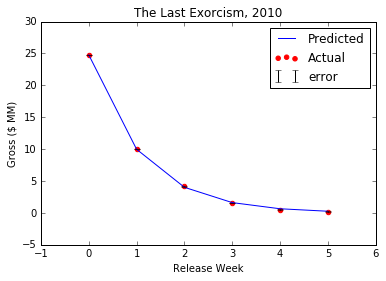

KeyboardInterrupt: 

In [5]:
# Plot decay fit for all movies in order of ascending error.

thresh = [[k,v[0]] for k,v in errors.items()]
thresh.sort(key = lambda x: x[1])
thresh_df = pd.DataFrame(thresh, columns=['movie','error'])
thresh_df['cdf'] = range(1,thresh_df.movie.count()+1)/thresh_df.movie.count()

for i in range(len(thresh)):
        l = thresh[i][0]
        x,y = range(t.movie[(t.movie==l[0])&(t.year==l[1])].count()), list(t[(t.movie==l[0])&(t.year==l[1])].Gross/1000000)
        popt, pcov = curve_fit(func, range(t.movie[(t.movie==l[0])&(t.year==l[1])].count()), t[(t.movie==l[0])&(t.year==l[1])].Gross/1000000)
        fitted = [popt[0]*np.exp(-popt[1]*m) for m in range(t.movie[(t.movie==l[0])&(t.year==l[1])].count())]
        bars = [(y[k]+fitted[k])/2 for k in range(len(y))]
        bar_dist = [abs(y[k]-bars[k]) for k in range(len(y))]
        pl.scatter(x,y,color='red',label='Actual')
        pl.plot(x,fitted,label='Predicted')
        pl.errorbar(range(len(y)),bars,yerr=bar_dist,fmt='none',ecolor='black',label='error')
        pl.title(l[0]+', '+str(l[1]))
        pl.ylabel('Gross ($ MM)')
        pl.xlabel('Release Week')
        pl.legend(loc=0)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        pl.close()
        sleep(.5)

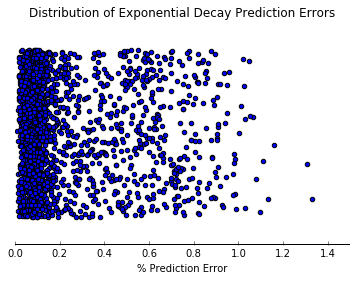

In [6]:
# Plot scatter of decay errors by movie

x = [i[0] for i in errors.values()]
y = [random.randint(0,5)+random.random() for i in errors.values()]

plt.axes(frameon=False)
ax1 = plt.scatter(x,y)
ax1.axes.get_yaxis().set_visible(False)
ax1.axes.get_xaxis().tick_bottom()
ax1.axes.set_xlim([0,1.5])
xmin, xmax = ax1.axes.get_xaxis().get_view_interval()
ymin, ymax = ax1.axes.get_yaxis().get_view_interval()
ax1.axes.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
plt.title('Distribution of Exponential Decay Prediction Errors')
plt.xlabel('% Prediction Error');

# Feature Creation and Exploration

In [7]:
# # Create features

movie = [i[0] for i in errors.keys()]
year = [i[1] for i in errors.keys()]
season_dict = dict(zip((1,2,3,4,5,6,7,8,9,10,11,12),(1,1,2,2,2,3,3,3,4,4,4,1)))
group_m = mov.groupby(['movie','year'],as_index=False).mean()

merged = pd.merge(mov,other_info, how='left').set_index(['movie','year'])
all_data = pd.get_dummies(merged.Genre,prefix='genre').reset_index()
genres = list(pd.get_dummies(merged.Genre,prefix='genre').columns)
action = [i for i in genres if 'action' in i.lower()]
comedy = [i for i in genres if 'comedy' in i.lower()]
scifi = [i for i in genres if 'sci-fi' in i.lower()]
romance = [i for i in genres if 'roman' in i.lower()]
horror = [i for i in genres if 'horror' in i.lower()]
drama = [i for i in genres if 'drama' in i.lower()]
genre_cat = zip(['action','comedy','scifi','romance','horror','drama'],[action,comedy,scifi,romance,horror,drama])
for i in genre_cat:
    genre = all_data[i[1]].sum(axis=1).rename(i[0])
    all_data = pd.concat([all_data,genre],axis=1)


all_data = pd.merge(all_data, pd.get_dummies(merged['MPAA Rating'],
                                             prefix='rating').groupby(level=(0,1)).mean().reset_index(),how='left')
all_data = pd.merge(all_data, merged.Budget.groupby(level=(0,1)).mean().reset_index(), how='left')
all_data = pd.merge(all_data, merged.Runtime.groupby(level=(0,1)).mean().reset_index(), how='left')
all_data = all_data.groupby(['movie','year']).mean().reset_index()
ratings = pd.DataFrame(ratings_search)[['audience','critics','movie','year']]
ratings.audience = pd.to_numeric(ratings.audience.str.replace('%',''), errors='coerce')
ratings.critics = pd.to_numeric(ratings.critics.str.replace('%',''), errors='coerce')
all_data = pd.merge(all_data, ratings, how='left')
all_data = pd.merge(all_data, merged[['director_points','actor_points']].groupby(level=(0,1)).mean().reset_index())
all_data = pd.merge(all_data, pd.DataFrame(franchise_info), how='left')
all_data = pd.merge(all_data,merged[merged.Day_Num<4].groupby(level=(0,1)).Rank.mean().reset_index(),how='left')
all_data = pd.merge(all_data,merged[merged.Day_Num<4].groupby(level=(0,1)).avg.mean().reset_index(),how='left')

rmonth = [int(group_m[(group_m.movie==i[0]) & (group_m.year==i[1])].rmonth) for i in errors.keys()]
rday = [int(group_m[(group_m.movie==i[0]) & (group_m.year==i[1])].rday) for i in errors.keys()]
rseason = [season_dict[i] for i in rmonth]

day_1_t_share = (mov.groupby(['movie','year']).Theaters.first()/
                    mov.groupby(['movie','year']).Theaters.max()).reset_index()
release_strat = [float(day_1_t_share[(day_1_t_share.movie==i[0]) & (day_1_t_share.year==i[1])].Theaters) for i in errors.keys()]

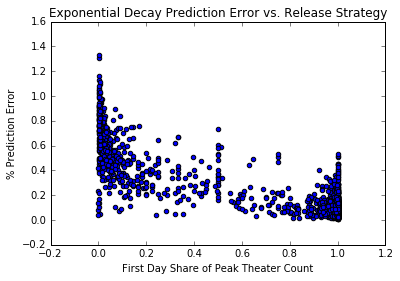

In [8]:
plt.scatter(release_strat,deviations)
plt.xlabel('First Day Share of Peak Theater Count')
plt.ylabel('% Prediction Error')
plt.title('Exponential Decay Prediction Error vs. Release Strategy');

In [10]:
# Compile features for modeling

data = pd.merge(pd.DataFrame(
    {'movie':movie,
     'year':year,
     'rmonth':rmonth,
     'rday':rday,
     'rseason':rseason,
     'release_strat':release_strat,
     'deviations':deviations,
     'betas':betas}), 
      all_data, how='left').set_index(['movie','year']).fillna(-1)

# Exponential Decay Error Prediction

0.806266894093
{'presort': False, 'splitter': 'best', 'max_leaf_nodes': None, 'min_samples_leaf': 50, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'max_features': None, 'max_depth': 3}


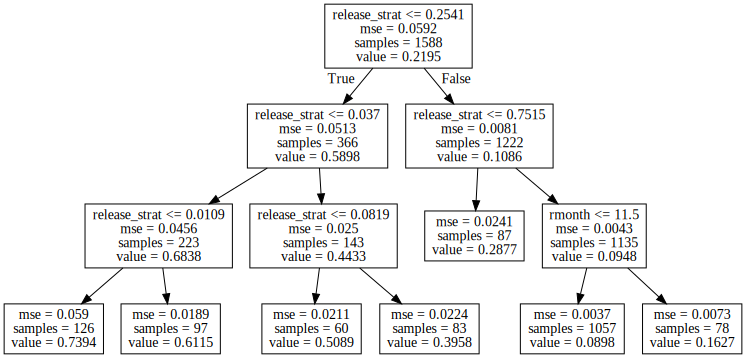

In [11]:
# Tree models for error prediction - fit and visualize

dat = data                                                 
y = pd.DataFrame(dat.deviations)
dat = dat.drop('deviations',axis=1)
dat = dat.drop('betas',axis=1)
dat = dat.drop('Rank',axis=1)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(dat, y, test_size=0.2,random_state=0)
cv = cross_validation.KFold(len(X_train), n_folds=5,shuffle=True,random_state=0)

# Get best depth for tree model with grid search

dtrmodel = tree.DecisionTreeRegressor(min_samples_leaf=50)
parameters = {'max_depth':np.arange(1,6,1)}
grid_searcher = grid_search.GridSearchCV(dtrmodel, parameters, cv=cv)
grid_searcher.fit(X_train,y_train)

best_model = grid_searcher.best_estimator_
print(best_model.score(X_test,y_test))
print(best_model.get_params())

data['pred_error'] = best_model.predict(dat)

export_graphviz(best_model, feature_names = X_train.columns,out_file="mytree.dot", max_depth=5)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

# Decay Parameter Prediction

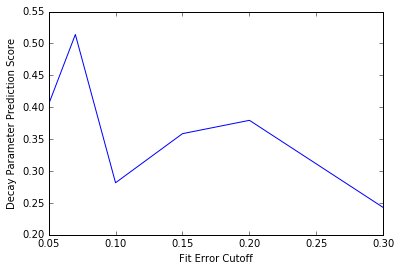

In [12]:
# Tree model - plot performance against error from exponential fit

scores = []
error_range = [.3,.2,.15,.1,.07,.05]

for i in range(len(error_range)):    
    dat = data[data.deviations<=error_range[i]]                                                  
    y = pd.DataFrame(dat.betas)
    dat = dat.drop('deviations',axis=1)
    dat = dat.drop('pred_error',axis=1)
    dat = dat.drop('betas',axis=1)
    dat = dat.drop('release_strat',axis=1)

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(dat, y, test_size=0.1,random_state=0)
    cv = cross_validation.KFold(len(X_train), n_folds=5,shuffle=True,random_state=0)

    dtrmodel = GradientBoostingRegressor(min_samples_split=100,min_samples_leaf=10,n_estimators=100)
    parameters =                            {
                                             'max_depth':np.arange(1,9,1)
                                            }
    grid_searcher = grid_search.GridSearchCV(dtrmodel, parameters, cv=cv)
    grid_searcher.fit(X_train,y_train.iloc[:,0])

    best_model = grid_searcher.best_estimator_
    scores.append(best_model.score(X_test,y_test))

plt.plot(error_range, scores)
plt.xlabel('Fit Error Cutoff')
plt.ylabel('Decay Parameter Prediction Score');

0.51409905872
{'presort': 'auto', 'loss': 'ls', 'verbose': 0, 'subsample': 1.0, 'max_leaf_nodes': None, 'learning_rate': 0.1, 'warm_start': False, 'min_samples_leaf': 10, 'n_estimators': 100, 'min_samples_split': 100, 'init': None, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'max_features': None, 'alpha': 0.9, 'max_depth': 2}


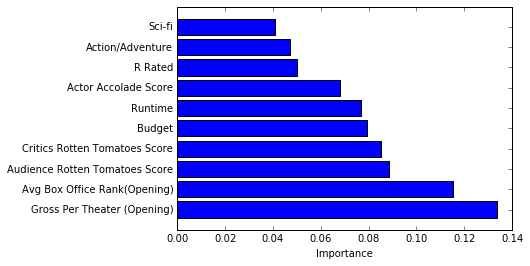

In [13]:
# Tree model - show top features

dat = data[data.deviations<=.07]                                            
y = pd.DataFrame(dat.betas)
dat = dat.drop('deviations',axis=1)
dat = dat.drop('pred_error',axis=1)
dat = dat.drop('betas',axis=1)
dat = dat.drop('release_strat',axis=1)


X_train, X_test, y_train, y_test = cross_validation.train_test_split(dat, y, test_size=0.1,random_state=0)
cv = cross_validation.KFold(len(X_train), n_folds=5,shuffle=True,random_state=0)

dtrmodel = GradientBoostingRegressor(min_samples_split=100,min_samples_leaf=10,n_estimators=100)
parameters =                            {
                                         'max_depth':np.arange(1,9,1)
                                        }
grid_searcher = grid_search.GridSearchCV(dtrmodel, parameters, cv=cv)
grid_searcher.fit(X_train,y_train.iloc[:,0])

best_model = grid_searcher.best_estimator_
print(best_model.score(X_test,y_test))
print(best_model.get_params())
s = sorted(zip(X_train.columns,best_model.feature_importances_),key = lambda x: x[1], reverse=True)[:10]
plt.barh(range(1,11), [i[1] for i in s],align = 'center')
ax = plt.gca()
ax.set_ylim([0,11])
plt.xlabel('Importance')
plt.yticks(range(1,11),['Gross Per Theater (Opening)',
                        'Avg Box Office Rank(Opening)',
                        'Audience Rotten Tomatoes Score',
                        'Critics Rotten Tomatoes Score',
                        'Budget',
                        'Runtime',
                        'Actor Accolade Score',
                        'R Rated',
                        'Action/Adventure',
                        'Sci-fi']);                       

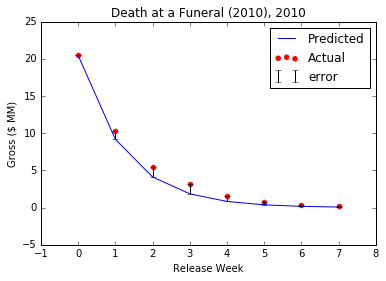

KeyboardInterrupt: 

In [14]:
# Plot fitted weekly box office revenue from exponential model with estimated parameter

eval = copy.deepcopy(X_test).reset_index()
test_movies = list(best_model.predict(X_test))
eval['beta'] = test_movies
test_movies = zip(list(eval.movie),list(eval.year))

for i in range(len(test_movies)):
        l = test_movies[i]
        x,y = range(t.movie[(t.movie==l[0])&(t.year==l[1])].count()), list(t[(t.movie==l[0])&(t.year==l[1])].Gross/1000000)
        fitted = [y[0]*np.exp(-eval.beta[i]*m) for m in range(t.movie[(t.movie==l[0])&(t.year==l[1])].count())]
        bars = [(y[k]+fitted[k])/2 for k in range(len(y))]
        bar_dist = [abs(y[k]-bars[k]) for k in range(len(y))]
        pl.scatter(x,y,color='red',label='Actual')
        pl.plot(x,fitted,label='Predicted')
        pl.errorbar(range(len(y)),bars,yerr=bar_dist,fmt='none',ecolor='black',label='error')
        pl.title(l[0]+', '+str(l[1]))
        pl.ylabel('Gross ($ MM)')
        pl.xlabel('Release Week')
        pl.legend(loc=0)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        pl.close()
        sleep(.5)

# Scraping

In [2]:
# [SCRAPE] Define scraper function for daily box office figures

def scrape_daily(page):
    data = page.find("table",{ "class" : "chart-wide" , "cellspacing" :0 })

    movie_data = []
    header = ['Day','Date','Rank','Gross','%YD','%LW','Theaters','Avg_Theater','GTD','Day_Num']
    for row in data.findAll('tr')[1:]:
        row_dict={}
        for i,cell in enumerate(row.findAll('td')):
            row_dict[header[i]] = cell.find(text=True)
        movie_data.append(row_dict)

#    movies_df = pd.DataFrame(movie_data)
#    movies_df = movies_df.dropna()

    return movie_data

In [318]:
# [SCRAPE] Create movie list by scraping box office mojo for all movies in specified years.

url_1 = 'http://www.boxofficemojo.com/yearly/chart/?yr='
url_2 = '&view=releasedate&view2=domestic&sort=gross&order=DESC&&p=.htm'
url_3 = 'http://www.boxofficemojo.com'

movie_list = {}
year_set = {}

for x in np.arange(2005,2017,1):
    
    year_set = {}
    url = url_1 + str(x) + url_2
    response = requests.get(url)
    page = response.text
    page = BeautifulSoup(page, 'html')
    range_max = [i.split(' -')[0] for i in 
           page.find("font", {"size" : "4", 
            "face" : "Verdana"}).text.splitlines()[0].encode('utf-8').split('\xc2\x96')][1:]
    links = ['none'] + [i['href'] for i in page.find("font", {"size" : "4", "face" : "Verdana"}).findAll("a")]
    
    year_set[x] = zip(range_max,links) 
    
    for i in page.find("table",{"cellspacing" :1, "cellpadding" : 5}).findAll('a')[10:]:
        if not (('view=bydate' in i['href']) | ('/studio/chart' in i['href'])):
            movie_list[(i.text,x)] = i['href']
    
    for n in sum(year_set.values(), [])[1:]:
        url = url_3 + n[1]
        response = requests.get(url)
        page = response.text
        page = BeautifulSoup(page, 'html')
        
        for i in page.find("table",{"cellspacing" :1, "cellpadding" : 5}).findAll('a')[10:]:
            if not (('view=bydate' in i['href']) | ('/studio/chart' in i['href'])):
                movie_list[(i.text,x)] = i['href']

In [8]:
# [SCRAPE] Get daily data from movie pages using movie_list

movies = pd.DataFrame(columns=['Day','Date','Rank','Gross','%YD','%LW','Theaters','Avg_Theater','GTD','Day_Num'])
  
daily_data = []   

for key in movie_list.keys(): 
    movie = key[0]
    year = key[1]
    mov_id = movie_list[key].index('id=')+3
    mov_id = movie_list[key][mov_id:]
    url = 'http://www.boxofficemojo.com/movies/?page=daily&view=chart&id='+mov_id
    response = requests.get(url)
    page = response.text
    page = BeautifulSoup(page, 'html')
    if page.text.find('NO DAILY DATA AVAILABLE')<0 and response.status_code<400:
        t = scrape_daily(page)
        t.append([movie,year])
        daily_data.append(t)
    
    sleep(0.01)

for i in daily_data:
    for j in range(len(i)-1):
        i[j]['movie'] = i[-1][0]
        i[j]['year'] = i[-1][1]
    del i[-1]

daily_data = sum(daily_data,[])

daily = pd.DataFrame(daily_data).dropna().reset_index().iloc[:,1:]

In [9]:
# [SCRAPE] Get other movie data (cast, genre, etc.) using movie_list

other = []
  
for key in movie_list.keys(): 
    movie = key[0]
    year = key[1]
    mov_id = movie_list[key].index('id=')+3
    mov_id = movie_list[key][mov_id:]
    
    url = 'http://www.boxofficemojo.com/movies/?id='+mov_id
    response = requests.get(url)
    page = response.text
    page = BeautifulSoup(page, 'html')
      
    try:
        general = {}

        for y in page.find("table", {"width": "95%"}).findAll("td"):
            general[y.text.split(': ')[0]] =  y.text.split(': ')[1]


        t = page.find(text = "The Players")
        t = t.findParent("div", {"class": "mp_box"})
        
        cast = {}
    
        for y in t.findAll("tr"):
            try:
                cast[y.find("a").text] = [j.text for j in y.findAll("a")[1:]]
            except:
                pass
    except:
        cast = {}
    
    other.append([(movie,year),general,cast])

In [134]:
# [SCRAPE] Get movie ratings from The Numbers

tn = {}

for i in np.arange(2005,2017,1):

    url = 'http://www.the-numbers.com/market/'+str(i)+'/top-grossing-movies'
    response = requests.get(url)
    page = response.text
    page = BeautifulSoup(page, "html")

    year = int(page.find("div", {"id":"page_filling_chart"}).findAll('a')[1].text)

    for i in page.find("table").findAll('tr')[1:]: 
        try:
            tn[(i.text.splitlines()[2],year)]=[i.find('a')['href']]
        except:
            pass

# # Match BOM movies with TN movies

bom = dat.reset_index()
to_rate = [[bom.movie[i],bom.year[i]] for i in range(len(bom))]

ratings_search = []

for i in np.arange(2005,2017,1):
    for_rating = [j for j in to_rate if i==j[1]]
    for_matching = [[k,j] for k,j in tn.items() if i==k[1]]
    for k in for_rating:
        match = np.array(([fuzz.ratio(k[0],j[0][0]) for j in for_matching])).argmax()
        tn_match = for_matching[match]
        movie = k[0]
        year = k[1]
        url = tn_match[1][0]
        search_dict = {'movie':movie,'year':year,'url':url}
        ratings_search.append(search_dict)

Get ratings from TN

url = 'http://www.the-numbers.com'

for i in ratings_search:
    response = requests.get(url+i['url'])
    page = response.text
    page = BeautifulSoup(page)
    t = sum([k.text.lower().splitlines() for k in page.find("table", {"id" : "movie_ratings"}).findAll("td")[1:]], [])
    try:
        critics = t[t.index('critics')+1].split(' ')[0]
    except:
        critics='none'
    try:
        audience = t[t.index('audience')+1].split(' ')[0]
    except:
        audience='none'
        pass
    i['critics'] = critics
    i['audience'] = audience

In [416]:
# [SCRAPE] Get Oscar information

driver = webdriver.Chrome(chromedriver)

awards = ['ACTOR IN A LEADING ROLE',
          'ACTOR IN A SUPPORTING ROLE',
          'ACTRESS IN A LEADING ROLE',
          'ACTRESS IN A SUPPORTING ROLE',
          'DIRECTING']

win_nom_set = []

for i in np.arange(1970,2016,1):

    url = 'http://awardsdatabase.oscars.org/ampas_awards/BasicSearchInput.jsp'
    driver.get(url)

    y_from = driver.find_element_by_xpath('//select[@name="BSFromYear"]')
    y_to = driver.find_element_by_xpath('//select[@name="BSToYear"]')
    y_from.send_keys(str(i))
    y_to.send_keys(str(i))
    search = driver.find_element_by_xpath('//input[@value="Search"]')
    search.click()

    page = BeautifulSoup(driver.page_source)
    
    win_nom = []
    
    for k in page.findAll("div", {"style":"margin-left: 35px"}):
        if k.text.splitlines()[1] in awards[0:4]:
            for j in k.findNextSiblings():
                try:
                    win_nom.append(['actor', j.text.splitlines()[2].split(" --")[0]])
                except:
                    break
        elif k.text.splitlines()[1] in awards[4:]:
            for j in k.findNextSiblings():
                try:
                    if j.text.splitlines()[2][0] == '*':
                        win_nom.append(['director','*' + j.text.splitlines()[2].split("-- ")[1]])
                    else:
                        win_nom.append(['director',j.text.splitlines()[2].split("-- ")[1]])
                except:
                    break
                
    for n in win_nom:
        t = {}
        if n[1][0]=='*':
            t['person'] = n[1][1:]
            t['year'] = i
            t['status'] = 'win'
            t['role'] = n[0]
        else:
            t['person'] = n[1]
            t['year'] = i
            t['status'] = 'nom'
            t['role'] = n[0]
        win_nom_set.append(t)
        
oscars = pd.DataFrame(win_nom_set)
oscars['pts'] = oscars.status.map({'nom':.5, 'win':1})

In [438]:
# Score movies based on Oscar information

bom_actors = sum([i for i in other_info.Actor if type(i)==list],[])
bom_actors = [i.split('*')[0] for i in bom_actors]

bom_directors = sum([i for i in other_info.Director if type(i)==list],[])
bom_directors = [i.split('*')[0] for i in bom_directors]

actor_awards = []
director_awards = []

for i in oscars.person.unique():
    match_bom = [j for j in bom_actors if j[0].lower()==i[0].lower()]
    actor_match = [fuzz.ratio(i,j) for j in match_bom]
    match = match_bom[np.array(actor_match).argmax()]
    if fuzz.ratio(i,match)>90:
        actor_awards.append({'person':i,
                             'role':'actor',
                             'bom_actor_name':match})
    match_bom = [j for j in bom_directors if j[0].lower()==i[0].lower()]
    actor_match = [fuzz.ratio(i,j) for j in match_bom]
    match = match_bom[np.array(actor_match).argmax()]
    if fuzz.ratio(i,match)>90:
        director_awards.append({'person':i,
                             'role':'director',
                             'bom_director_name':match})

oscar_pts = pd.merge(pd.merge(oscars, pd.DataFrame(actor_awards), 
                  how='left'), pd.DataFrame(director_awards), how='left')

actor_points = []
director_points = []

for i in range(len(other_info)):
    movie = other_info.movie[i]
    year = other_info.year[i]
    actor_pts = 0
    director_pts = 0
    if type(other_info.Actor[i])==list:
        actors = other_info.Actor[i]
        for j in actors:
            actor_pts += sum(oscar_pts.pts[(oscar_pts.bom_actor_name==j.split('*')[0]) & (oscar_pts.year<year)]) 
    to_append = {'movie':movie,
                 'year':year,
                 'actor_points':actor_pts}
    actor_points.append(to_append)
    if type(other_info.Director[i])==list:
        director = other_info.Director[i]
        for j in director:
            director_pts += sum(oscar_pts.pts[(oscar_pts.bom_director_name==j.split('*')[0]) & (oscar_pts.year<year)]) 
    to_append = {'movie':movie,
                 'year':year,
                 'director_points':director_pts}
    director_points.append(to_append)

In [611]:
# [SCRAPE] Get franchise information
 
urls = ['http://www.imdb.com/list/ls003495084/?start=1&view=compact&sort=listorian:asc&defaults=1',
        'http://www.imdb.com/list/ls003495084/?start=251&view=compact&sort=listorian:asc',
        'http://www.imdb.com/list/ls003495084/?start=501&view=compact&sort=listorian:asc',
        'http://www.imdb.com/list/ls003495084/?start=751&view=compact&sort=listorian:asc',
        'http://www.imdb.com/list/ls003495084/?start=1001&view=compact&sort=listorian:asc']

franchise_movies = []

for i in urls:
    response = requests.get(i)
    page = response.text
    page = BeautifulSoup(page)
    franchises = zip(page.findAll("td", {"class":"title"}),page.findAll("td", {"class":"year"}))
    for i in franchises:
        try:
            franchise_movies.append([i[0].text, int(i[1].text)])
        except:
            franchise_movies.append([i[0].text, 0])

In [620]:
# [SCRAPE] Append franchise information

franchise_info = []

for i in np.arange(2005,2017,1):
    for_rating = [j for j in to_rate if i==j[1]]
    for_matching = [j for j in franchise_movies if abs(i-j[1])<2]
    for k in for_rating:
        movie = k[0]
        year = k[1]
        match = np.array(([fuzz.ratio(k[0],j[0]) for j in for_matching])).argmax()
        if fuzz.ratio(k[0],for_matching[match][0])>80:
            franchise = 1
        else:
            franchise = 0
        franch_dict = {'movie':movie, 'year':year, 'franchise':franchise}
        franchise_info.append(franch_dict)